In [25]:
# import relevant libraries

import pandas as pd
from sklearn.metrics import classification_report

In [26]:
# load data into dataframe

df_2024 = pd.read_csv("/content/combined_data.csv")

In [27]:
print(df_2024.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554119 entries, 0 to 554118
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   YEAR             554119 non-null  int64  
 1   MONTH            554119 non-null  int64  
 2   DAY              554119 non-null  int64  
 3   HOUR             554119 non-null  int64  
 4   MINUTE           554119 non-null  int64  
 5   SHIFT            554119 non-null  object 
 6   METHOD           554119 non-null  object 
 7   OFFENSE          554119 non-null  object 
 8   BLOCK            554119 non-null  object 
 9   WARD             554119 non-null  int64  
 10  ANC              554119 non-null  object 
 11  DISTRICT         554119 non-null  int64  
 12  PSA              554119 non-null  int64  
 13  VOTING_PRECINCT  554119 non-null  object 
 14  LATITUDE         554119 non-null  float64
 15  LONGITUDE        554119 non-null  float64
dtypes: float64(2), int64(8), object(6)
mem

In [28]:
# Drop rows where offense is "ARSON"
df_2024 = df_2024[df_2024["OFFENSE"] != "ARSON"]

In [29]:
df_2024["OFFENSE"].unique()

array(['THEFT', 'ASSAULT W/DANGEROUS WEAPON', 'ROBBERY',
       'MOTOR VEHICLE THEFT', 'BURGLARY', 'HOMICIDE', 'SEX ABUSE'],
      dtype=object)

In [30]:
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"ROBBERY": "THEFT", "BURGLARY": "THEFT"})
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"MOTOR VEHICLE THEFT" : "THEFT"})
df_2024["OFFENSE"].unique()

array(['THEFT', 'ASSAULT W/DANGEROUS WEAPON', 'HOMICIDE', 'SEX ABUSE'],
      dtype=object)

In [31]:
df_2024["OFFENSE"].value_counts()

,count
OFFENSE,
THEFT,513520
ASSAULT W/DANGEROUS WEAPON,33817
SEX ABUSE,3784
HOMICIDE,2620


In [32]:
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"HOMICIDE": "VIOLENT CRIME"})
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"SEX ABUSE": "VIOLENT CRIME"})
df_2024["OFFENSE"] = df_2024["OFFENSE"].replace({"ASSAULT W/DANGEROUS WEAPON" : "VIOLENT CRIME"})

df_2024["OFFENSE"].unique()

array(['THEFT', 'VIOLENT CRIME'], dtype=object)

In [33]:
df_2024["OFFENSE"].value_counts()

,count
OFFENSE,
THEFT,513520
VIOLENT CRIME,40221


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define X (features) and y (target)
x_independent = df_2024.drop(columns=['OFFENSE', "METHOD"])  # Drop the target variable
y_dependent = df_2024['OFFENSE']  # Target variable

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_dependent)

# Define categorical and numerical columns
categorical_cols = ['SHIFT', 'ANC', 'VOTING_PRECINCT', "BLOCK"]  # Categorical features
numerical_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'WARD', 'DISTRICT', 'PSA', 'LATITUDE', 'LONGITUDE']  # Numerical features

# Label encode categorical variables
for col in categorical_cols:
    le = LabelEncoder()
    x_independent[col] = le.fit_transform(x_independent[col])

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(x_independent, y_encoded, test_size=0.20, random_state=42)

# Print shapes of the training and test sets
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (442992, 14), X_test shape: (110749, 14)
y_train shape: (442992,), y_test shape: (110749,)


In [35]:
print(label_encoder.classes_)

['THEFT' 'VIOLENT CRIME']


In [36]:
from imblearn.under_sampling import RandomUnderSampler

# 'THEFT' is the majority class (label 0) that needs to undersample

# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42, sampling_strategy={0: 40221})

# Resample the training data
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Now, X_train_resampled and y_train_resampled contain the undersampled data

In [37]:
from imblearn.over_sampling import SMOTE
sampling_strategy = {1: 40221}  # Specify the label and desired number of samples

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

In [38]:
# Check the new class distribution
print(f"Original class distribution:\n{y_train.shape}")
print(f"Resampled class distribution:\n{y_resampled.shape}")

Original class distribution:
(442992,)
Resampled class distribution:
(80442,)


In [39]:
from xgboost import XGBClassifier

# Create and configure the XGBoost model
model_xgb = XGBClassifier(
    eval_metric='mlogloss',         # Set evaluation metric for multi-class classification
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=None,
    tree_method='hist'
)
# Fit the model
model_xgb.fit(X_resampled, y_resampled, verbose=True)

# Make predictions
y_pred = model_xgb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83    102679
           1       0.17      0.70      0.27      8070

    accuracy                           0.72    110749
   macro avg       0.57      0.71      0.55    110749
weighted avg       0.91      0.72      0.79    110749



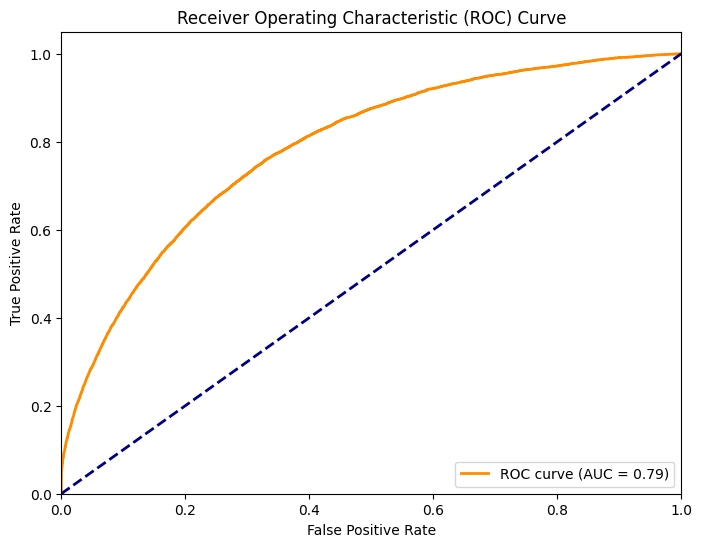

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [41]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=2000, random_state=42)
# Fit the model
model_lr.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.96      0.68      0.80    102679
           1       0.14      0.67      0.23      8070

    accuracy                           0.68    110749
   macro avg       0.55      0.68      0.52    110749
weighted avg       0.90      0.68      0.76    110749



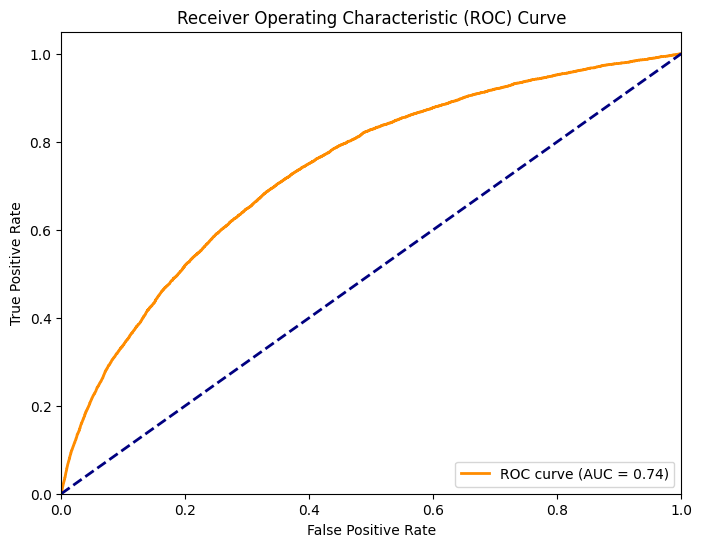

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_lr.predict_proba(X_test)

# Assuming a binary classification problem (adjust if multi-class)
# For multi-class, you'll need to loop through each class and plot ROC curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [43]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier()
# Fit the model
model_lgb.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_lgb.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 40221, number of negative: 40221
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 80442, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.97      0.71      0.82    102679
           1       0.16      0.71      0.26      8070

    accuracy                           0.71    110749
   macro avg       0.56      0.71      0.54    110749
weighted avg       0.91      0.71      0.78    110749



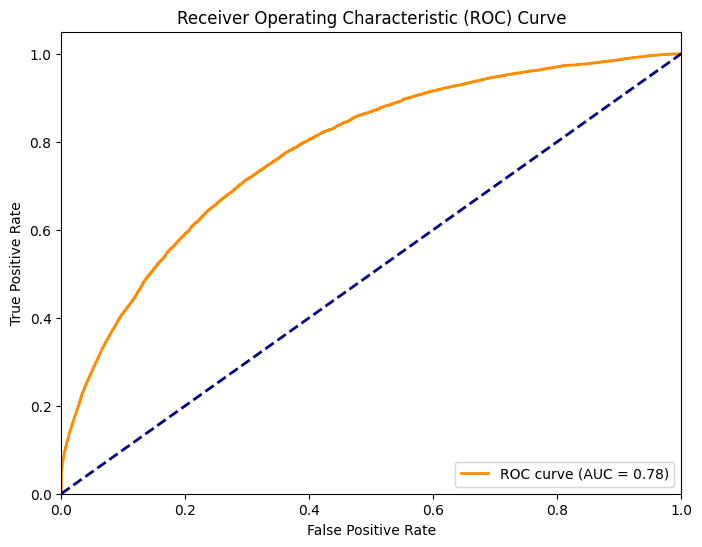

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_lgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [46]:
from catboost import CatBoostClassifier

model_cbc = CatBoostClassifier(silent=True, random_state=42)
# Fit the model
model_cbc.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_cbc.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83    102679
           1       0.17      0.71      0.27      8070

    accuracy                           0.72    110749
   macro avg       0.57      0.71      0.55    110749
weighted avg       0.91      0.72      0.79    110749



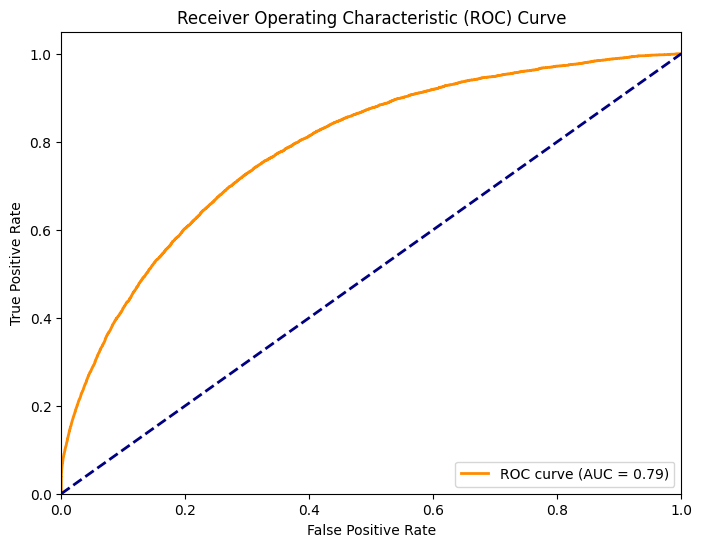

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_cbc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [48]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
# Fit the model
model_knn.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_knn.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.64      0.77    102679
           1       0.13      0.65      0.21      8070

    accuracy                           0.64    110749
   macro avg       0.54      0.65      0.49    110749
weighted avg       0.90      0.64      0.73    110749



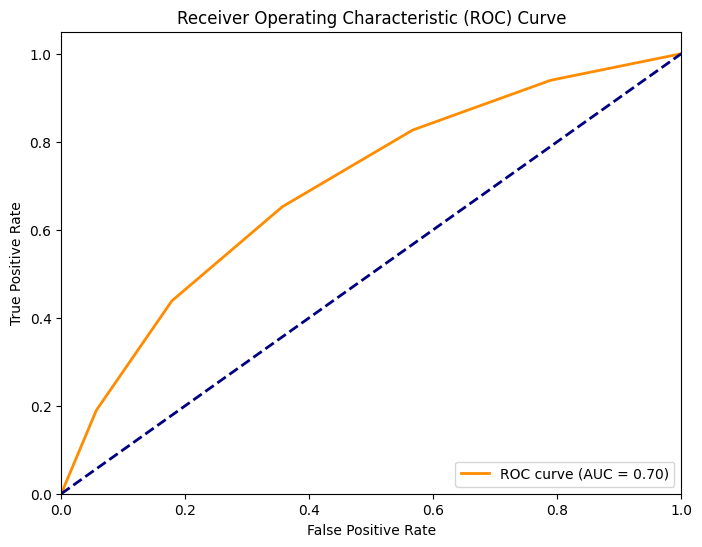

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_knn.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [50]:
from sklearn.naive_bayes import GaussianNB

model_naivebayes = GaussianNB()
# Fit the model
model_naivebayes.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_naivebayes.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81    102679
           1       0.14      0.63      0.23      8070

    accuracy                           0.69    110749
   macro avg       0.55      0.66      0.52    110749
weighted avg       0.90      0.69      0.76    110749



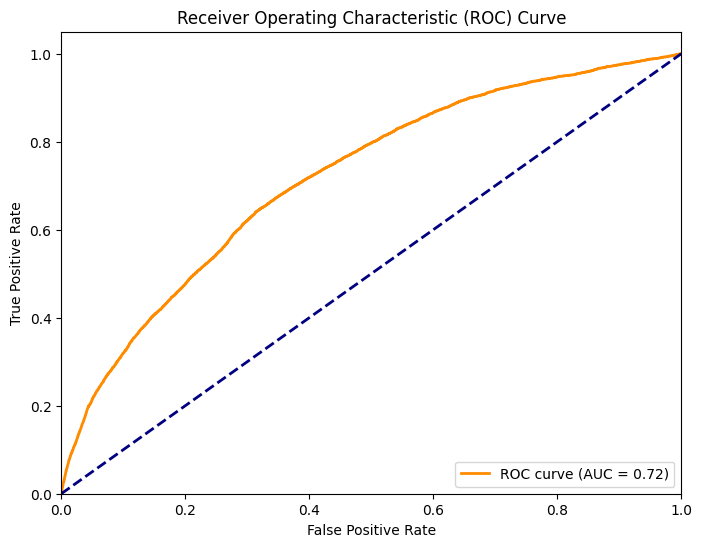

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_naivebayes.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [52]:
from sklearn.ensemble import RandomForestClassifier

model_randomforest = RandomForestClassifier(random_state=42)
# Fit the model
model_randomforest.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model_randomforest.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83    102679
           1       0.17      0.68      0.27      8070

    accuracy                           0.73    110749
   macro avg       0.57      0.71      0.55    110749
weighted avg       0.91      0.73      0.79    110749



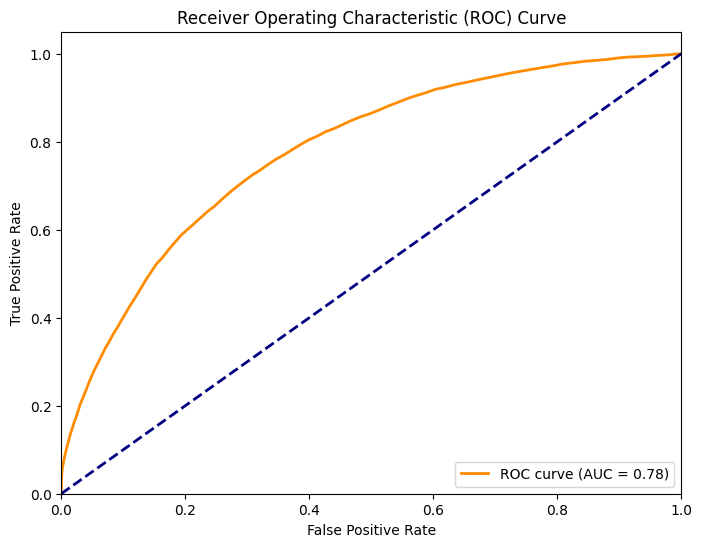

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = model_randomforest.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()